## FERC <> EIA Granular Connections

Notes on the type of problem we are trying to solve:
- A classification problem
    - A Multi-Class Classification problem*
- A deterministic problem
- A record linkage problem

Right now, we are using the recordlinkage package. We're using logistic regression classifier because it fits all of the above.

To consider:
- Maybe we want to run the records with fuel cost data through a different matching model...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
from copy import deepcopy
import scipy
import statistics
import yaml

import recordlinkage as rl
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
sys.path.append("../")
from pudl.output.ferc1 import *
from connect_ferc1_to_eia import *
from make_plant_parts_eia import *
import connect_ferc1_to_eia #ferc_eia_connections
pudl_settings = pudl.workspace.setup.get_defaults()
#pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pudl_engine = sa.create_engine('sqlite:////Users/christinagosnell/code/pudl_work/sqlite/pudl_wo_ytd.sqlite')
pd.options.display.max_columns = None

### Pull in data (EIA, FERC and training)

In [25]:
file_path_training = pathlib.Path().cwd().parent /'train_ferc1_to_eia.csv'
file_path_mul = pathlib.Path().cwd().parent /'outputs' /'master_unit_list.pkl.gz'
# pudl output object for ferc data
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS',fill_fuel_cost=True,roll_fuel_cost=True,fill_net_gen=False)

In [26]:
inputs = InputManager(file_path_training, file_path_mul, pudl_out)
features_all = (Features(feature_type='all', inputs=inputs)
                .get_features(clobber=False))
features_train = (Features(feature_type='training', inputs=inputs)
                  .get_features(clobber=False))
tuner = ModelTuner(features_train, inputs.get_train_index(), n_splits=10)

matcher = MatchManager(best=tuner.get_best_fit_model(), inputs=inputs)
matches_best = matcher.get_best_matches(features_train, features_all)

Preparing the FERC1 steam table.
Reading the master unit list from /Users/christinagosnell/code/rmi-ferc1-eia/outputs/master_unit_list.pkl.gz
Generated 71790 all candidate features.
Generated 315 training candidate features.
We are about to test hyper parameters of the model while doing k-fold cross validation. This takes a few minutes....
Scores from the best model hyperparameters:
  F-Score:   0.87
  Precision: 0.86
  Accuracy:  0.75
Fit and predict a model w/ the highest scoring hyperparameters.
Get the top scoring match for each FERC1 steam record.
Winning match stats:
        matches vs ferc:      32.09%
        best match v ferc:    26.49%
        best match vs matches:82.57%
        murk vs matches:      9.31%
        ties vs matches:      5.36%
Overridden records: 15.1%


In [37]:
matcher = MatchManager(best=tuner.get_best_fit_model(), inputs=inputs)
matches_best = matcher.get_best_matches(features_train, features_all)

Fit and predict a model w/ the highest scoring hyperparameters.
Get the top scoring match for each FERC1 steam record.
Winning match stats:
        matches vs ferc:      84.68%
        best match v ferc:    71.61%
        best match vs matches:84.56%
        murk vs matches:      7.33%
        ties vs matches:      5.36%
Overridden records: 16.3%
New best match v ferc:    73.24%


In [41]:
# export for connect_deprish_to_ferc1
#file_path_steam_ferc1 = pathlib.Path().cwd().parent / 'outputs' /'steam_ferc1.pkl.gz'
#inputs.steam_df.to_pickle(file_path_steam_ferc1, compression='gzip')

file_path_ferc1_eia = pathlib.Path().cwd().parent / 'outputs'/ 'ferc1_to_eia.pkl.gz'
matches_best.to_pickle(file_path_ferc1_eia, compression='gzip')
file_path_ferc1_eia_csv = pathlib.Path().cwd().parent / 'outputs'/ 'ferc1_to_eia.csv.gz'
matches_best.to_csv(file_path_ferc1_eia_csv)

In [40]:
matches_best

,record_id_ferc1,score,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,plant_name,total_fuel_cost,total_mmbtu,rank,diffs,count,iqr,iqr_all,record_id_eia
0,f1_steam_2009_12_100_0_1,8.429633,-0.284998,3.036443,-1.639126,1.786141,1.752696,0.225354,3.505409,0.047715,-1.214569e-128,0.000000e+00,1.0,6.541852,6.0,0.154527,0.154527,6641_2009_plant_owned_12685
1,f1_steam_2009_12_100_0_2,6.072496,-0.284911,1.436325,-1.725615,1.786141,0.000000,0.000000,4.823277,0.044388,-7.108971e-03,3.016803e-07,1.0,1.382073,3.0,1.491320,4.420149,2053_st_2009_plant_prime_mover_total_12685
2,f1_steam_2009_12_100_0_4,7.936660,-0.285017,3.036443,-0.000000,0.000000,0.000000,0.225354,4.900788,0.055609,-8.933799e-02,9.282145e-02,1.0,4.527918,3.0,2.539437,2.539437,2051_2009_plant_total_12685
3,f1_steam_2009_12_100_0_5,9.618624,-0.285011,2.953411,-1.749334,1.786141,1.797163,0.225354,4.833318,0.057583,-1.287108e-13,5.525724e-207,1.0,7.850773,3.0,4.062485,4.062485,2050_2009_plant_total_12685
4,f1_steam_2009_12_100_1_1,6.718586,-0.284994,2.953411,-1.685602,1.786141,1.588956,0.225354,2.077738,0.057583,-1.067425e-18,3.723233e-231,1.0,NaN,1.0,0.000000,0.000000,8054_2009_plant_total_12685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7618,f1_gnrt_plant_2018_12_312_0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7619,f1_gnrt_plant_2018_12_312_0_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7620,f1_gnrt_plant_2018_12_312_0_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7621,f1_steam_2016_12_186_4_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3803_2016_plant_total_19876


### Investigating Comparison Feature Vectors

In [17]:
features_train.describe().T

,count,mean,std,min,25%,50%,75%,max
plant_name,315.0,0.766342,0.121989,0.000000e+00,7.038126e-01,7.777778e-01,0.857143,0.939394
net_generation_mwh,315.0,0.208743,0.383594,0.000000e+00,0.000000e+00,6.535031e-44,0.095555,1.000000
capacity_mw,315.0,0.395785,0.455791,2.324785e-96,5.808251e-14,2.609650e-02,0.986233,1.000000
total_fuel_cost,315.0,0.103976,0.200360,0.000000e+00,0.000000e+00,1.039511e-150,0.000596,0.500000
total_mmbtu,315.0,0.133529,0.249637,0.000000e+00,0.000000e+00,0.000000e+00,0.000246,1.000000
capacity_factor,315.0,0.907369,0.140853,0.000000e+00,8.801637e-01,9.656464e-01,0.995487,1.000000
fuel_cost_per_mmbtu,315.0,0.412289,0.450402,0.000000e+00,0.000000e+00,0.000000e+00,0.926839,0.999960
heat_rate_mmbtu_mwh,315.0,0.328901,0.438235,0.000000e+00,0.000000e+00,0.000000e+00,0.862684,1.000000
fuel_type_code_pudl,315.0,0.666667,0.472155,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.000000
installation_year,315.0,0.580952,0.494188,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.000000


In [18]:
features_all.describe().T

,count,mean,std,min,25%,50%,75%,max
plant_name,71790.0,0.737402,0.111267,0.0,6.750000e-01,7.500000e-01,8.222222e-01,1.000000
net_generation_mwh,71790.0,0.137682,0.308169,0.0,0.000000e+00,6.172515e-130,5.734110e-06,1.000000
capacity_mw,71790.0,0.126064,0.291771,0.0,2.578682e-19,3.669096e-08,1.964083e-02,1.000000
total_fuel_cost,71790.0,0.098793,0.203567,0.0,0.000000e+00,7.011830e-276,8.281211e-08,1.000000
total_mmbtu,71790.0,0.092886,0.199899,0.0,0.000000e+00,0.000000e+00,3.635321e-51,1.000000
capacity_factor,71790.0,0.868497,0.227514,0.0,8.326960e-01,9.668734e-01,9.952145e-01,1.000000
fuel_cost_per_mmbtu,71790.0,0.273990,0.411428,0.0,0.000000e+00,0.000000e+00,7.917092e-01,0.999976
heat_rate_mmbtu_mwh,71790.0,0.190431,0.363298,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
fuel_type_code_pudl,71790.0,0.608776,0.488028,0.0,0.000000e+00,1.000000e+00,1.000000e+00,1.000000
installation_year,71790.0,0.407424,0.491358,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000


### Explore Classificaiton Model

In [19]:
matcher.best

,precision,f_score,accuracy,coef,interc,predictions,solver,c,cw,penalty,l1,multi_class
0,0.853118,0.871414,0.755828,"[0.0, 3.6612282877007765, 2.7179049259183587, ...",-0.287363,255,liblinear,1,None,l1,None,auto


In [20]:
weights = pd.DataFrame(
    data={'feature': features_all.columns,
          'weight': matcher.coefs
         })
weights

,feature,weight
0,plant_name,0.000000
1,net_generation_mwh,3.661228
2,capacity_mw,2.717905
3,total_fuel_cost,0.000000
4,total_mmbtu,0.000000
5,capacity_factor,0.000000
6,fuel_cost_per_mmbtu,-1.250128
7,heat_rate_mmbtu_mwh,1.429698
8,fuel_type_code_pudl,1.337342
9,installation_year,0.196200


In [21]:
def plot_all_hist(all_df,results_df,murk_df, matches_best_df, range):
    if all_df is not None:
        plt.hist(all_df['score'], 
                 range=range,
                 bins=100,
                 color="pink",
                 label='all options'
                )
    if results_df is not None:
        plt.hist(results_df['score'], 
                 range=range,
                 bins=100,
                 color="purple",
                 label='all model matches'
                )
    if matches_best_df is not None:
        plt.hist(matches_best_df['score'], 
                 range=range,
                 bins=100,
                 color="turquoise",
                 label='winning options'
                )
    if murk_df is not None:
        plt.hist(murk_df['score'], 
                 range=range,
                 bins=100,
                 color="grey",
                 label='murky wins'
                )

    plt.title(f'weighted score of comparision features')
    plt.xlabel('weighted sum')
    plt.ylabel(None)
    plt.legend()
    plt.show()

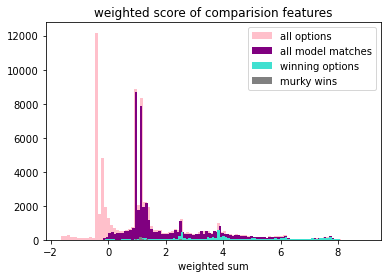

In [22]:
plot_all_hist(matcher.calc_match_stats(features_all),
              matcher.matches_model,
              matcher.murk_df,
              matches_best,
              range=None)

In [38]:
wins = (matches_best.reset_index().merge(inputs.plant_parts_df.
              reset_index()[['record_id_eia','plant_part','capacity_mw']],
              on=['record_id_eia'],
              how='left',
              suffixes=('_feature','')
             ).
        groupby(['plant_part']).
        agg({'capacity_mw':sum,
             'score': 'count'}).
        assign(count_w=lambda x: x.capacity_mw * x.score,
               percent_w=lambda x: x.count_w/x.sum()['count_w'],
               percent=lambda x: x.score/x.sum()['score'],
              )
       )

wins.round(2)

,capacity_mw,score,count_w,percent_w,percent
plant_part,,,,,
plant,2273600.05,4038,9.180797e+09,0.87,0.54
plant_ferc_acct,1402.60,4,5.610400e+03,0.00,0.00
plant_gen,89223.59,665,5.933369e+07,0.01,0.09
plant_prime_fuel,120846.50,186,2.247745e+07,0.00,0.02
plant_prime_mover,688462.76,1477,1.016860e+09,0.10,0.20
plant_technology,121479.80,163,1.980121e+07,0.00,0.02
plant_unit,337595.53,920,3.105879e+08,0.03,0.12
